# CYCLING IN SYDNEY

In [47]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import math
from datetime import datetime

In [48]:
%matplotlib inline

In [49]:
plt.rcParams['figure.figsize'] = (10, 5)

In [50]:
saved_style_state = matplotlib.rcParams.copy()

## 1. importing data

In [51]:
if os.path.isfile("Cycleway Counts_01Jan18_11Sept20.xlsx"):
    filepath = "Cycleway Counts_01Jan18_11Sept20.xlsx"
    print("loading from file")
else:
    filepath = "https://opendata.transport.nsw.gov.au/system/files/resources/Cycleway%20Counts_01Jan18_11Sept20.xlsx"
    print("loading from the internet")

cycleway_usage = pd.read_excel(filepath, sheet_name="daily counts")
print("done")


loading from file
done


# 1.a ben's assistance

In [52]:
dir_lookup = ["North", "East", "South", "West", "All Directions"]
def get_mode(index):
    if index<5:
        return "Cycling"
    else:
        return "Pedestrian"

locations_sparse = [x for x in cycleway_usage.columns if "Unnamed" not in x ]

In [53]:
def get_loc(i, response_type="all"):
    try:
        loc = locations_sparse[math.ceil(i/15)]
        if response_type == "all":
            return loc
        elif response_type == "code":
            return loc.split("-")[0].strip()
        elif response_type == "name":
            return loc.split("-")[1].strip()
        # You can extend this to pull out the notes, like (Cycleway and Pedestrian counter), but they're pretty inconsistent
        else:
            print(f"`{response_type}` is not implemented yet")
    except:
        print("er")


In [54]:
new_rows = []
for i, row in cycleway_usage.iterrows():
    if i < 3:
        continue  # This feels nasty

    date = row[0]
    for loc_index in range(1, len(row) - 15, 15):
        section = row[
            loc_index : loc_index + 10
        ]  # 10 because we don't care about the Sum (All Transport Modes) section
        for col_index, col in enumerate(section):
            dir = dir_lookup[col_index % 5]
            if type(col) is int and col != 0 and dir != "All Directions":
                r = {
                    "date": date,
                    "location_name": get_loc(loc_index, "name"),
                    "station": get_loc(loc_index, "code"),
                    "mode_transport": get_mode(col_index),
                    "direction": dir,
                    "counter": int(col),
                }
                new_rows.append(r)

# 1.b converting datetime

In [55]:
time_df = pd.DataFrame(new_rows)
time_df.head()

,date,location_name,station,mode_transport,direction,counter
0,02/01/2018,"Falcon St Pedestrian Bridge , Cammeray (Cyclew...",100008,Cycling,North,9
1,02/01/2018,"Falcon St Pedestrian Bridge , Cammeray (Cyclew...",100008,Cycling,South,5
2,02/01/2018,"Falcon St Pedestrian Bridge , Cammeray (Cyclew...",100008,Pedestrian,North,7
3,02/01/2018,"Falcon St Pedestrian Bridge , Cammeray (Cyclew...",100008,Pedestrian,South,7
4,02/01/2018,"Ridge St Bridge, North Sydney (Cycleway and Pe...",100009,Pedestrian,East,88


In [56]:
time_df.iloc[0].date

'02/01/2018'

In [57]:
time_df['date_dt'] = pd.to_datetime(time_df['date'], infer_datetime_format=True, dayfirst=True)
time_df.sort_values(by='date_dt', inplace=True) 
time_df.set_index("date_dt", inplace=True)
time_df.head()

,date,location_name,station,mode_transport,direction,counter
date_dt,,,,,,
2018-01-02,02/01/2018,"Falcon St Pedestrian Bridge , Cammeray (Cyclew...",100008,Cycling,North,9
2018-01-02,02/01/2018,"Liverpool to Parramatta Rail Trail, Railway Te...",90905,Cycling,South,35
2018-01-02,02/01/2018,"Cooks River Cycleway, Marrickville South (Ped ...",90909,Cycling,East,270
2018-01-02,02/01/2018,"Cooks River Cycleway, Marrickville South (Ped ...",90909,Cycling,West,255
2018-01-02,02/01/2018,"Cooks River Cycleway, Marrickville South (Ped ...",90909,Pedestrian,East,75


In [58]:
print(time_df.shape) 

(43329, 6)


### Questions
* Who is travelling into the city, out of the city?
* Weekdays vs weekend? See comparison, poor connections? Limitations of only pathways/single counter?

## 2. data visualisation over time
* per day/ per month bar chart
* section off weekends?
* weekdays?

In [62]:
station_df = time_df[time_df.station=="100008"]

Text(0.5, 0, 'Falcon St Pedestrian Bridge , Cammeray (Cycleway and Pedestrian counter)')

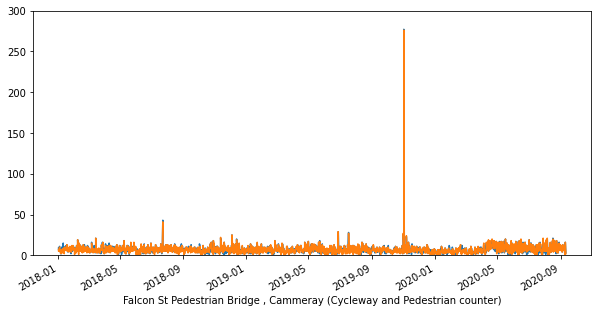

In [67]:
# AxesSubplot:xlabel= if station=="100008" use location_name
station_df[station_df.direction=="North"]["counter"].plot( )
station_df[station_df.direction=="South"]["counter"].plot( )
plt.ylim([0, 300])
plt.xlabel(station_df.iloc[0].location_name)

In [59]:
AxesSubplot:xlabel= if station=="90909" use location_name

time_df[(time_df.station=="90909") & (time_df.direction=="East")]["counter"].plot( )
time_df[(time_df.station=="90909") & (time_df.direction=="West")]["counter"].plot( )
plt.ylim([0, 300])

SyntaxError: invalid syntax (3754687945.py, line 1)

<AxesSubplot:xlabel='date_dt'>

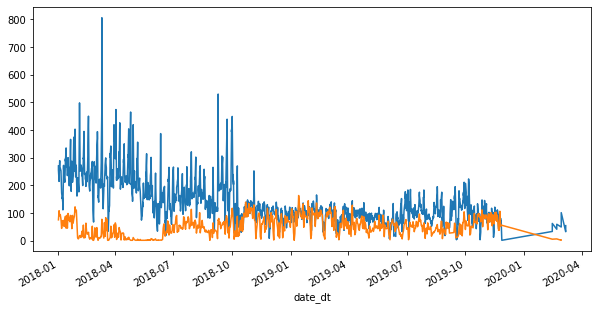

In [61]:
time_df[(time_df.station=="90909") & (time_df.mode_transport=="Cycling")]["counter"].plot( )
time_df[(time_df.station=="90909") & (time_df.mode_transport=="Pedestrian")]["counter"].plot( )

## 3. data visualisation linked to location
* plot points on a map
* set size relation to counter (int)
* set colour/arrow relation to counter/direction
* where is there a lot of cycling? 

In [31]:
if os.path.isfile("cyclecounters-Oct-2019.csv"):
    counterfilepath = "cyclecounters-Oct-2019.csv"
    print("loading from file")
else:
    counterfilepath = "https://opendata.transport.nsw.gov.au/node/6771/download"
    print("loading from the internet")

cycleway_counterlocation = pd.read_csv(counterfilepath)
print("done")

loading from file
done


In [32]:
cycleway_counterlocation.sort_values(by='station', inplace=True)
cycleway_counterlocation.head(26)

,objectid,station,region,geolocation,location,shortname,notes,y_2018_oct,y_2018_nov,y_2018_dec,...,y_2012,y_2013,y_2014,y_2015,y_2016,y_2017,y_2018,y_2019,y_max_year,active
8,9,30011,Metro Sydney Inner West,-33.860980 151.164268,"Iron Cove Bridge cycleway, near King George Pa...",Iron Cove Bridge,Interruptions due to construction work 2010/11...,0,0,0,...,552,563,646,603,627,563,504,400,800,Y
0,1,90902,Sydney City,-33.858959 151.206218,"Sydney Harbour Bridge bicycle path, near Upper...",Sydney Harbour Bridge,None,1744,1974,1549,...,1807,1932,1853,1671,1729,1707,1663,1464,2000,Y
1,2,90903,Sydney City,-33.867926 151.181554,"Anzac Bridge cycleway, near Quarry Master Driv...",Anzac Bridge,Counter inoperable from Feb 2015 to Oct 2015.,1249,1433,1122,...,1414,1457,1376,1111,1236,1223,1208,1090,1500,Y
21,22,90904,Metro Sydney West Central,-33.89126 150.94075,"Liverpool to Parramatta Rail Trail, Broomfield...",Liverpool to Paramatta Rail Trail Cabramatta,Closed in 2012 due to work on Southern Sydney ...,25,0,0,...,23,0,0,31,33,33,28,32,50,Y
22,23,90905,Metro Sydney West Central,-33.851949 150.986339,"Liverpool to Parramatta Rail Trail, Railway Te...",Liverpool to Parramatta Rail Trail Guildford,Counter inoperable Mar 2014 to June 2015.,69,73,70,...,79,80,86,64,69,61,71,63,120,Y
2,3,90907,Sydney City,-33.89582 151.221849,"Anzac Parade cycleway, near Lang Road, Moore Park",Anzac Parade,Counter inoperable December 2013 to June 2015.,812,895,927,...,943,1029,1145,983,979,929,831,571,1100,N
7,8,90908,Metro Sydney Inner North,-33.817990 151.089939,"North Ryde to Sydney Olympic Park cycleway, ne...",North Ryde to Sydney Olympic Park,Counter inoperable June 2015 to Nov 2015.,379,376,377,...,358,417,423,452,284,551,431,433,500,Y
25,26,90910,Metro Sydney South,-33.9874 151.07716,"Como Bridge cycleway, near Oatley Parade, Oatley",Como Bridge,2010/11 - cycleway partially inaccessible due ...,129,116,129,...,291,287,253,241,236,232,213,144,850,NaN
12,13,90911,Metro Sydney North,-33.76469 151.105899,"Lane Cove River Walk, near Browns Waterhole, M...",Lane Cove River Walk,None,0,0,0,...,140,168,199,176,180,170,178,0,180,N
13,14,90912,Metro Sydney North West,-33.75367 150.966419,"Crestwood Reserve cycleway, near Merindah Road...",Crestwood Reserve,None,0,1,1,...,48,50,61,59,32,36,49,6,90,N


In [33]:
import geopandas as gp

ModuleNotFoundError: No module named 'geopandas'

In [34]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.Collecting geopandas
     ---------------------------------------- 1.0/1.0 MB 8.3 MB/s eta 0:00:00
     ---------------------------------------- 6.4/6.4 MB 45.6 MB/s eta 0:00:00
     ---------------------------------------- 1.3/1.3 MB 41.5 MB/s eta 0:00:00
     ---------------------------------------- 1.0/1.0 MB 68.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'



  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [1 lines of output]
      A GDAL API version must be specified. Provide a path to gdal-config using a GDAL_CONFIG environment variable or use a GDAL_VERSION environment variable.
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.

[notice] A new release of pip available: 22.2.1 -> 22.2.2
[notice] To update, run: C:\Users\Bojana.Pavlovic\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## 4. next steps?
* import datasets from Strava, Google Maps, layer over data
* understand why cycling is used: recreation/commuting?
* understand why cycling is *NOT* used
* start playing with cycle pathways?
* feed into research: making Parramatta road a cycleway